## 4.3 컬러 이미지를 분류하는 CNN 구현
CNN을 이용해 사진을 분류하는 방법을 다룹니다.

### 4.3.1 분류 CNN 패키지 임포트

1. 필요한 패키지들을 임포트합니다.

---
### 4.3.6 전체 코드

In [1]:
# set to use CPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
# 1. 분류 CNN 패키지 임포트 
from sklearn import model_selection, metrics
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import os

from keras import backend as K
from keras.utils import np_utils
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from keraspp import skeras
from keraspp import sfile

# 2. 분류 CNN 모델링
class CNN(Model):
    def __init__(model, nb_classes, in_shape=None):
        super(CNN,model).__init__() # added 2021-10-01
        model.nb_classes = nb_classes
        model.in_shape = in_shape
        model.build_model()
        super().__init__(model.x, model.y)
        model.compile()

    def build_model(model):
        nb_classes = model.nb_classes
        in_shape = model.in_shape

        x = Input(in_shape)

        h = Conv2D(32, kernel_size=(3, 3), activation='relu',
                   input_shape=in_shape)(x)
        h = Conv2D(64, (3, 3), activation='relu')(h)
        h = MaxPooling2D(pool_size=(2, 2))(h)
        h = Dropout(0.25)(h)
        h = Flatten()(h)
        z_cl = h

        h = Dense(128, activation='relu')(h)
        h = Dropout(0.5)(h)
        z_fl = h

        y = Dense(nb_classes, activation='softmax', name='preds')(h)

        model.cl_part = keras.models.Model(x, z_cl)
        model.fl_part = Model(x, z_fl)

        model.x, model.y = x, y

    def compile(model):
        Model.compile(model, loss='categorical_crossentropy',
                      optimizer='adadelta', metrics=['accuracy'])

# 3. 분류 CNN을 위한 데이터 준비
class DataSet:
    def __init__(self, X, y, nb_classes, scaling=True, 
                 test_size=0.2, random_state=0):
        """
        X is originally vector. Hence, it will be transformed
        to 2D images with a channel (i.e, 3D).
        """
        self.X = X
        self.add_channels()

        X = self.X
        # the data, shuffled and split between train and test sets
        X_train, X_test, y_train, y_test = model_selection.train_test_split(
            X, y, test_size=0.2, random_state=random_state)

        print(X_train.shape, y_train.shape)

        X_train = X_train.astype('float32')
        X_test = X_test.astype('float32')

        if scaling:
            # scaling to have (0, 1) for each feature (each pixel)
            scaler = MinMaxScaler()
            n = X_train.shape[0]
            X_train = scaler.fit_transform(
                X_train.reshape(n, -1)).reshape(X_train.shape)
            n = X_test.shape[0]
            X_test = scaler.transform(
                X_test.reshape(n, -1)).reshape(X_test.shape)
            self.scaler = scaler

        print('X_train shape:', X_train.shape)
        print(X_train.shape[0], 'train samples')
        print(X_test.shape[0], 'test samples')

        # convert class vectors to binary class matrices
        Y_train = np_utils.to_categorical(y_train, nb_classes)
        Y_test = np_utils.to_categorical(y_test, nb_classes)

        self.X_train, self.X_test = X_train, X_test
        self.Y_train, self.Y_test = Y_train, Y_test
        self.y_train, self.y_test = y_train, y_test
        # self.input_shape = input_shape

    def add_channels(self):
        X = self.X

        if len(X.shape) == 3:
            N, img_rows, img_cols = X.shape

            if K.image_dim_ordering() == 'th':
                X = X.reshape(X.shape[0], 1, img_rows, img_cols)
                input_shape = (1, img_rows, img_cols)
            else:
                X = X.reshape(X.shape[0], img_rows, img_cols, 1)
                input_shape = (img_rows, img_cols, 1)
        else:
            input_shape = X.shape[1:]  # channel is already included.

        self.X = X
        self.input_shape = input_shape

# 4. 분류 CNN의 학습 및 성능 평가를 위한 머신 클래스
class Machine():
    def __init__(self, X, y, nb_classes=2, fig=True):
        self.nb_classes = nb_classes
        self.set_data(X, y)
        self.set_model()
        self.fig = fig

    def set_data(self, X, y):
        nb_classes = self.nb_classes
        self.data = DataSet(X, y, nb_classes)
        print('data.input_shape', self.data.input_shape)

    def set_model(self):
        nb_classes = self.nb_classes
        data = self.data
        self.model = CNN(nb_classes=nb_classes, in_shape=data.input_shape)

    def fit(self, epochs=10, batch_size=128, verbose=1):
        data = self.data
        model = self.model

        history = model.fit(data.X_train, data.Y_train, 
                            batch_size=batch_size, epochs=epochs,
                            verbose=verbose, 
                            validation_data=(data.X_test, data.Y_test))
        return history

    def run(self, epochs=100, batch_size=128, verbose=1):
        data = self.data
        model = self.model
        fig = self.fig

        history = self.fit(epochs=epochs,
                           batch_size=batch_size, verbose=verbose)

        score = model.evaluate(data.X_test, data.Y_test, verbose=0)

        print('Confusion matrix')
        Y_test_pred = model.predict(data.X_test, verbose=0)
        y_test_pred = np.argmax(Y_test_pred, axis=1)
        print(metrics.confusion_matrix(data.y_test, y_test_pred))

        print('Test score:', score[0])
        print('Test accuracy:', score[1])

        # Save results
        suffix = sfile.unique_filename('datatime')
        foldname = 'output_' + suffix
        os.makedirs(foldname)
        skeras.save_history_history(
            'history_history.npy', history.history, fold=foldname)
        model.save_weights(os.path.join(foldname, 'dl_model.h5'))
        print('Output results are saved in', foldname)

        if fig:
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 2, 1)
            skeras.plot_acc(history)
            plt.subplot(1, 2, 2)
            skeras.plot_loss(history)
            plt.show()

        self.history = history

        return foldname

(40000, 32, 32, 3) (40000, 1)
X_train shape: (40000, 32, 32, 3)
40000 train samples
10000 test samples
data.input_shape (32, 32, 3)


2021-10-01 19:24:54.658927: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-10-01 19:24:54.872913: E tensorflow/stream_executor/cuda/cuda_driver.cc:313] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-10-01 19:24:54.872954: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (SJKIM-Home): /proc/driver/nvidia/version does not exist
2021-10-01 19:24:54.874117: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2021-10-01 19:24:54.883798: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 3599995000 Hz
2021-10-01 19:24:54.884569: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x559ff95f4c10 initialized for platform Host (this does not guarantee that XLA will be used). Devi

Epoch 1/2
313/313 [==============================] - 59s 188ms/step - loss: 2.3098 - accuracy: 0.1000 - val_loss: 2.2927 - val_accuracy: 0.1169
Epoch 2/2
313/313 [==============================] - 51s 164ms/step - loss: 2.2973 - accuracy: 0.1141 - val_loss: 2.2832 - val_accuracy: 0.1529
Confusion matrix
[[569  31  11   1   1   9   2   0 268 112]
 [374  87  35   2   0  15  17   1 287 168]
 [686  24  36   1   0  31  11   3 156  68]
 [655  26  34   8   7  59  17   2 155  67]
 [714  30  12   3   3  34   7   0  82  82]
 [653  21  42   5   3  72  19   1 141  59]
 [652  41  51   3   7  47  30   0  75  47]
 [647  31  18   4   2  24   4   6 113 150]
 [347  50  11   0   7  18   6   0 407 143]
 [321  53   8   0   2  14   2   1 328 311]]
Test score: 2.2832424640655518
Test accuracy: 0.15289999544620514
Output results are saved in output_b05c1b32-ec10-4ca9-a38a-4d588c80ee7d


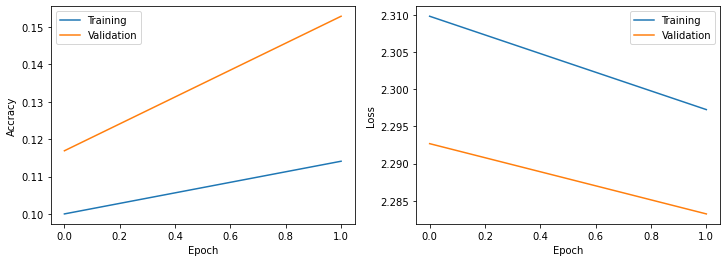

In [3]:
# 5. 분류 CNN의 학습 및 성능 평가 수행
from keras import datasets
import keras
assert keras.backend.image_data_format() == 'channels_last'

# from keraspp import aicnn


class MyMachine(Machine):
    def __init__(self):
        (X, y), (x_test, y_test) = datasets.cifar10.load_data()
        super(MyMachine,self).__init__(X, y, nb_classes=10)


def main():
    m = MyMachine()
    m.run(epochs=2)

if __name__ == '__main__':
    main()